### Import 

In [16]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
#import shapefile
import geopandas
#import rbf as RBF
import warnings
import lavavu

In [17]:
from FME.geological_points import IePoint, IPoint, GPoint, TPoint
from FME.geological_interpolator import GeologicalInterpolator
from FME.tet_mesh import TetMesh
from FME.dsi_interpolator import DSI
from FME.foldframe import FoldFrame
from FME.fold import FoldEvent, DSIFoldConstraint
#from FME.structural_frame import StructuralFrame
from FME.fault_segment import FaultSegment
from FME.region_manager import RegionManager
from FME.helper import *
from FME.svariogram import s_variogram#

### Load data using geopandas
* **geopandas**  is handy library for loading shapefiles and other geoscientific data sets as pandas data frames. 
* It means that the data can be manipulated as a pandas data frame which is very powerful

In [18]:
points = geopandas.read_file('data.gpkg',layer='points')
orientations = geopandas.read_file('data.gpkg',layer='orientations')
model_area = geopandas.read_file('data.gpkg',layer='bounding_box')

### Mesh model area

In [19]:
geom = model_area['geometry']#.shapes()
coords = np.array(geom[0].exterior.coords)#[0]
minz = -(np.max(coords[:,0])-np.min(coords[:,0]))/2.

In [36]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = np.min(coords[:,0])-10 
boundary_points[0,1] = np.min(coords[:,1])
boundary_points[0,2] = minz
boundary_points[1,0] = np.max(coords[:,0])
boundary_points[1,1] = np.max(coords[:,1])
boundary_points[1,2] = -minz*0.1
mesh = TetMesh('NoddySingleFold',)
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=100000,)
regionmanager = RegionManager(mesh)
cg = mesh.get_constant_gradient(region=mesh.regions['everywhere'],shape='square')
mesh.save()

### Some helper functions for plotting structural data on a map

In [37]:
def strike_symbol(strike):
    R = np.zeros((2,2))
    R[0,0] = np.cos(np.deg2rad(-strike))
    R[0,1] = -np.sin(np.deg2rad(-strike))
    R[1,0] = np.sin(np.deg2rad(-strike))
    R[1,1] = np.cos(np.deg2rad(-strike)) 
    R = np.zeros((2,2))
    R[0,0] = np.cos(np.deg2rad(-strike))
    R[0,1] = -np.sin(np.deg2rad(-strike))
    R[1,0] = np.sin(np.deg2rad(-strike))
    R[1,1] = np.cos(np.deg2rad(-strike))
    
    vec = np.array([0,1])
    rotated = R@vec
    vec2 = np.array([-0.5,0])
    r2 = R@vec2
    return rotated,r2
def plot_strike(x,y,strike,scale=100,colour='black'):
    rotated, r2 = strike_symbol(-strike)
    rotated*=scale
    r2*=scale
    plt.plot([x,x+rotated[0]],[y,y+rotated[1]],colour)
    plt.plot([x-rotated[0],x],[y-rotated[1],y],colour)
    plt.plot([x,x+r2[0]],[y,y+r2[1]],'k-')



### Make a map of structural data 
**This needs to be made more intuative**

Text(0.5, 1.0, 'Bedding and S0 observations')

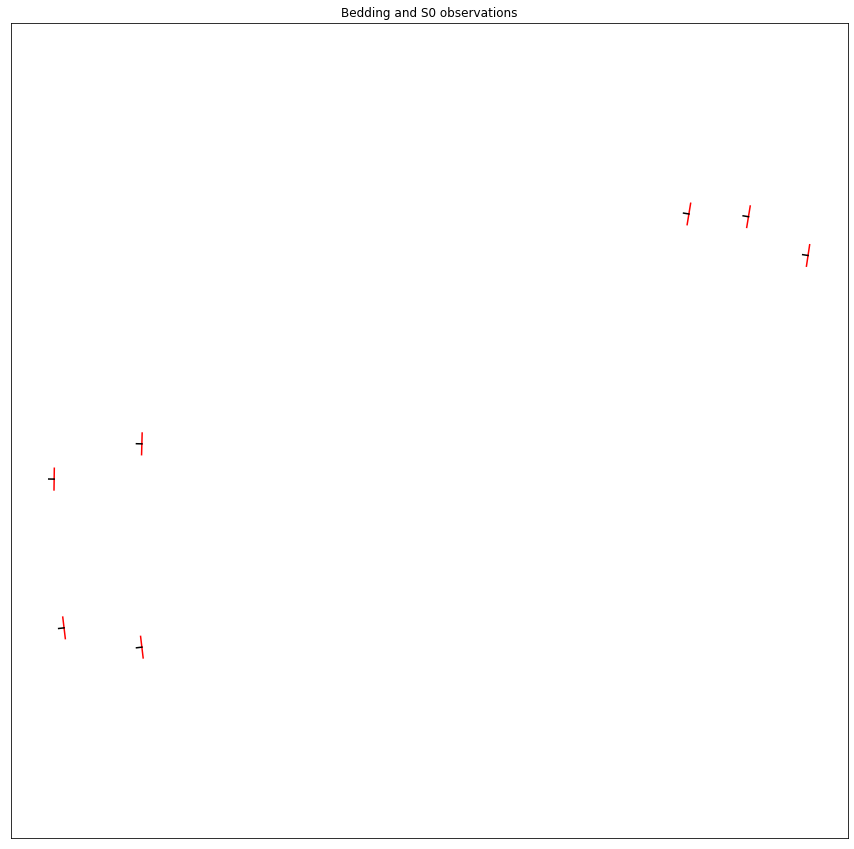

In [38]:
plt.figure(figsize=(15,15))
for i,o in orientations.iterrows():
    if o['type'] == 's1' and o['itype'] =='gx':#print(o)
        plot_strike(o['geometry'].xy[0][0],o['geometry'].xy[1][0],o['strike'],colour='red')
#     if o['type'] == 's0':
#         plot_strike(o['geometry'].xy[0][0],o['geometry'].xy[1][0],o['strike'],colour='black')
plt.gca().get_yaxis().set_visible(False)#axis('equal')
plt.gca().get_xaxis().set_visible(False)#axis('equal')
plt.axis('equal')
plt.title('Bedding and S0 observations')

### Build fault frame from S1 observations

In [39]:
fold_f1 = FoldFrame(mesh=mesh,region='everywhere',shape='square',name='Fold_f1')
for i, r in orientations.iterrows():
    if r['type'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fold_f1.add_strike_and_dip([xy[0][0],xy[1][0],z],r['strike'],r['dip'],itype=r['itype'])
for i, r in points.iterrows():
    if r['type'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fold_f1.add_point([xy[0][0],xy[1][0],z],r['value'],itype=r['itype'])

fold_f1.buildFrame(solver='chol')

Setting up interpolator with 1 value control points 
        7 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000
Setting up interpolator with 1 value control points 
        7 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


### Calculate fold axis rotation angles

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


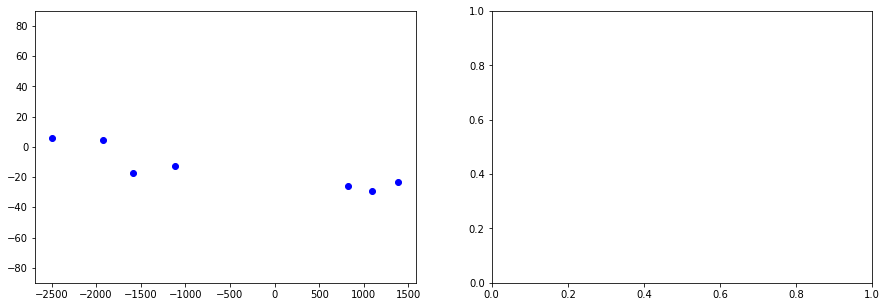

In [40]:
#from helper import strike_dip_vector
nans = np.zeros(len(orientations))
nans[:] = np.nan
orientations['x'] = nans
orientations['y'] = nans
orientations['z'] = nans
for i,r in orientations.iterrows():
    orientations.at[i,'x'] = r['geometry'].xy[0][0]
    orientations.at[i,'y'] = r['geometry'].xy[1][0]
    orientations.at[i,'z'] = 0.0
s0 = orientations[orientations['type'] == 's0']
xyz = s0.loc[:,['x','y','z']].as_matrix()
s0g = strike_dip_vector(s0.loc[:,'strike'],s0.loc[:,'dip'])
s0g /= np.linalg.norm(s0g,axis=1)[:,None]
l1 = fold_f1.calculate_intersection_lineation(np.hstack([xyz,s0g]))
far = fold_f1.calculate_fold_axis_rotation(np.hstack([xyz,l1]))                                        
s1 = fold_f1.get_gx(xyz,grad=False)
s1gy = fold_f1.get_gy(xyz,grad=False)

##quick figure
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(s1gy,far,'bo')
ax[0].set_ylim(-90,90)
#ax[0].ylim(-90,90)
# svario = s_variogram(s1gy,far)
# svario.setup()
guess = [4000]
# guess = svario.find_wavelengths()
# ax[1].plot(svario.h,svario.var,'bo')
# #ax[1].axvline(guess[0])

### Use RBF to interpolate fold axis rotation angle

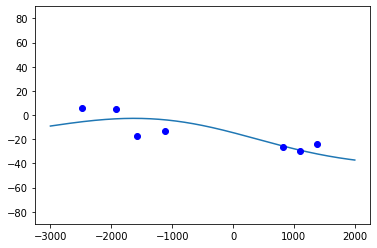

In [41]:
from scipy.interpolate import Rbf
far_tan = np.tan(np.deg2rad(far))
rbf_fold_axis = Rbf(s1gy,np.zeros(s1gy.shape),np.zeros(s1gy.shape),far_tan,function='gaussian',epsilon=guess[0],smooth=.1)
xi = np.linspace(-3000,2000,1000)
plt.plot(xi,np.rad2deg(np.arctan(rbf_fold_axis(xi,np.zeros(1000),np.zeros(1000)))))
plt.plot(s1gy,far,'bo')
plt.ylim(-90,90)
def fold_axis_rotation(x):
    return np.rad2deg(np.arctan(rbf_fold_axis(x,np.zeros(x.shape),np.zeros(x.shape))))

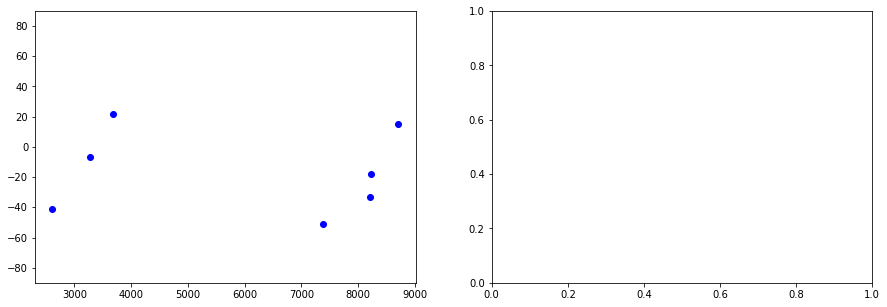

In [42]:
fold = FoldEvent(fold_f1,fold_axis_rotation,None)
axis = fold.get_fold_axis_orientation(xyz)
axis/=np.linalg.norm(axis,axis=1)[:,None]
flr = fold_f1.calculate_fold_limb_rotation(np.hstack([xyz,s0g]),axis=axis)
##quick figure
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(s1,flr,'bo')
ax[0].set_ylim(-90,90)
#ax[0].ylim(-90,90)
svario = s_variogram(s1,flr)
svario.setup()
# guess = svario.find_wavelengths()
# ax[1].plot(svario.h,svario.var,'bo')
#ax[1].axvline(guess[1])
guess = np.array(guess)
guess[0] = 2500

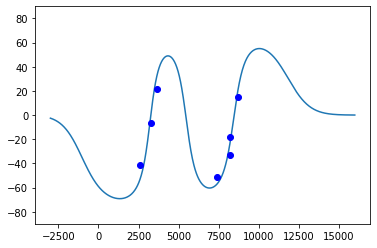

In [43]:
flr_tan = np.tan(np.deg2rad(flr))
rbf_fold_limb = Rbf(s1,np.zeros(s1.shape),np.zeros(s1.shape),flr_tan,function='gaussian',epsilon=guess[0],smooth=.05)
xi = np.linspace(-3000,16000,1000)
plt.plot(xi,np.rad2deg(np.arctan(rbf_fold_limb(xi,np.zeros(1000),np.zeros(1000)))))
plt.plot(s1,flr,'bo')
plt.ylim(-90,90)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(rbf_fold_limb(x,np.zeros(x.shape),np.zeros(x.shape))))

In [44]:
#update the fold event to have a real fold_limb_rotation function
fold.fold_limb_rotation = fold_limb_rotation
const = DSIFoldConstraint(fold,mesh,shape='square') 
const.use_deformed_orientation_cnstrt(50.) 
const.use_fold_axis_cnstrt(3.) 
const.use_regularisation_cnstrt(10.) 
const.use_normalisation_cnstrt()

A, B, row, col = const.get_constraints()
deformed_orientation, fold_axis, dgz = fold.get_deformed_orientation(mesh.barycentre)
mesh.property_gradients['fold'] = deformed_orientation 
mesh.property_gradients['axis'] = fold_axis 
mesh.update_property('foldrot',fold_limb_rotation(mesh.properties[fold_f1.interpolators['gx'].propertyname]))

In [45]:
stratigraphy = DSI(mesh,region='everywhere',shape='square',solver='chol')
stratigraphy.add_point(mesh.pca.inverse_transform([0,0,0]),0.)
stratigraphy.setup_interpolator(cg=False,cgw=0.)
stratigraphy.A.extend(A)
stratigraphy.row.extend(row)
stratigraphy.col.extend(col)
stratigraphy.B+=B
stratigraphy.solve_system(solver='chol',clear=True)
mesh.update_property('strati',stratigraphy.c)

Setting up interpolator with 1 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000


### Plot resulting model


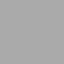

In [46]:
nslices = 5
vector_slicing = 100
colours = {}
lv = lavavu.Viewer()
# mesh.
# for interpolator in fault.interpolators:
#     v = mesh.properties[fault.interpolators[interpolator].propertyname]
#     s=0
#     #for s in np.linspace(np.min(v)+0.1,np.max(v)-0.1,nslices):
#     mesh.lv_plot_isosurface(
#             fault.interpolators[interpolator].propertyname,
#             colour=colours[interpolator],
#             isovalue=s,#np.mean(mesh.properties[fault.interpolators['gx'].propertyname]),
#             name=fault.interpolators[interpolator].propertyname+"_%f"%s,
#             interactive=False,
#             lv=lv,
#             draw=False,
#     #          region="r1"
#     #         region="FaultSegmentRegion%i"%s
#         )
#     gy_grad = lv.vectors(fault.interpolators[interpolator].propertyname+"_grad",colour=colours[interpolator],scaling=3)
#     gy_grad.vertices(mesh.barycentre[::vector_slicing,:])#
#     gy_grad.vectors(mesh.property_gradients[fault.interpolators[interpolator].propertyname]\
#                     [::vector_slicing,:]/np.linalg.norm(mesh.property_gradients[fault.interpolators[interpolator]\
#                     .propertyname][::vector_slicing,:],axis=1)[:,None])
v = mesh.properties['strati']
for s in np.linspace(np.min(v)+0.1,np.max(v)-0.1,nslices):
    mesh.lv_plot_isosurface(
                   'strati',
                   colour='purple',
                   isovalue=s,#np.mean(mesh.properties[fault.interpolators['gx'].propertyname]),
                   name="strati_%f"%s,#fault.interpolators[interpolator].propertyname+"_%f"%s,
                   interactive=False,
                   lv=lv,
                   draw=False
               )
#lv.objects['r1']['opacity']=0.6
lv.control.Panel()
lv.control.ObjectList()
lv.control.show()